# 第9章: RNN, CNN
>参考: Pytorchチュートリアル https://yutaroogawa.github.io/pytorch_tutorials_jp/

# 80. ID番号への変換
>問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ

In [1]:
!head -3 ../Chap8/train.txt

	TITLE	CATEGORY
0	RPT-Fitch Updates EMEA Consumer ABS Rating Criteria & Auto Residual Value  ...	b
1	Gurlitt Wants to Return Nazi-Looted Art, Sueddeutsche Reports	e


In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
import nltk
import torch.optim as optim
import time

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nagasawa_h/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
first_line = True  # 'TITLE    CATEGORY'の行を読み飛ばすための変数

with open('../Chap8/train.txt') as f:
    word_count = collections.Counter()
    for line in f:
        if first_line:
            first_line = False
            continue
            
        # うまくTITLEとCATEGORYの2つに絞れていない行があるので, エラー回避するためにsplit数で条件分岐
        if len(line.split('\t')) != 3:
            # print('Line excluded.')
            continue
        
        _, title, category = line.strip('\n').split('\t')
        words = nltk.word_tokenize(title)
        word_count.update(words)


dict_word_to_id = {}
c = 1

for word, count in word_count.most_common():
    if count >= 2:
        dict_word_to_id[word] = c
        c+=1
    else:
        dict_word_to_id[word] = 0
        
def text_to_ids(text: str) -> list:
    return [dict_word_to_id[word] if (word in dict_word_to_id.keys()) else 0 for word in nltk.word_tokenize(text)]

def list_to_tensor(input_data: list):
    return torch.tensor([input_data])

In [4]:
input_line = 'Gurlitt Wants to Return Nazi-Looted Art'
print(text_to_ids(input_line))
print(list_to_tensor(text_to_ids(input_line)).topk(1))

[6649, 555, 1, 791, 0, 2547]
torch.return_types.topk(
values=tensor([[6649]]),
indices=tensor([[0]]))


# 81. RNNによる予測
>ID番号で表現された単語列x=(x1,x2,…,xT)  
ただし，Tは単語列の長さ，xt∈ℝVは単語のID番号のone-hot表記である（Vは単語の総数である）  
再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列xからカテゴリyを予測するモデルを実装せよ

In [5]:
def one_hot_vectorizer(text: str):
    token_ids = text_to_ids(text)
    vocab_len = max(word_to_id.values()) + 1
    tensor = torch.zeros(len(token_ids), vocab_len)
    for i, idx in enumerate(token_ids):
        tensor[i][idx] = 1
        
    return tensor



class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size, output_size):
        super(RNN, self).__init__()
        
        # 変数の設定
        self.num_layers = 1
        self.hidden_size = hidden_size
        
        # vocab_sizeが語彙のサイズで, emb_dimが埋め込む次元数
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        
        # 入力がinput_size次元で, 隠れ状態の表現がhidden_size次元, num_layers層のRNN. 
        # biasでバイアス項の有無,non_linearityで活性化関数の指定ができる(tanh or ReLU)
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_size,
                          num_layers=self.num_layers, bias=True, nonlinearity='tanh', batch_first=True)
        
        # 全結合層
        self.fc = nn.Linear(hidden_size, output_size, bias=True)
        
    def forward(self, x):
        embed = self.embedding(x)
        init_hidden = self.initHidden()   # h0ベクトルの作成
        output, final_hidden = self.rnn(embed, init_hidden)
        model_output = self.fc(final_hidden[0])   # 問題の指示により, 使用するのは隠れ層ベクトル
        model_output = F.softmax(model_output, dim=-1)
        
        return model_output
        
    def initHidden(self):
        return torch.zeros(1, self.num_layers, self.hidden_size)

In [6]:
# モデルの出力がどのカテゴリかを返す関数
def category_from_output(output):
    idx = torch.argmax(output).item()
    all_categories = {0:'b', 1:'t', 2:'e', 3:'m'}
    return all_categories[idx]

params = {
'vocab_size': max(dict_word_to_id.values()) + 1,
'emb_dim': 300,
'hidden_size': 50,
'output_size': 4
}

my_rnn = RNN(**params)
input_x = 'Gurlitt Wants to Return Nazi-Looted Art, Sueddeutsche Reports'
input_x = text_to_ids(input_x)
input_x = list_to_tensor(input_x)
pred_y = my_rnn(input_x)
print(f'モデル予測: {category_from_output(pred_y)}')   # なおこの予測はデタラメなもの
print(pred_y)
print('正解: e')
# print(f'topk: {y.dim.topk(1)}')

モデル予測: e
tensor([[0.1566, 0.1399, 0.4028, 0.3007]], grad_fn=<SoftmaxBackward>)
正解: e


# 82. 確率的勾配降下法による学習
>確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ

In [7]:
!head -3 ../Chap8/valid.txt

	TITLE	CATEGORY
10672	Swiss stocks - Factors to watch on March 31	b
10673	Jamie Foxx Will Reportedly Play Mike Tyson In Upcoming Biopic	e


In [8]:
def get_data(file):
    titles = []
    categories = []
    first_line = True
    with open(file) as f:
        for line in f:
            if first_line:
                first_line=False
                continue
                
            if len(line.split('\t')) != 3:
                continue
                
            contents = line.strip('\n').split('\t')
            titles.append(contents[1])
            categories.append(contents[2])
            
    return titles, categories

def get_accuracy(net, x_list, y_list):  
    acc = 0.0
    for x, y in zip(x_list, y_list):
        output = category_from_output(net(list_to_tensor(text_to_ids(x))))
        if output == y:
            acc += 1.0
            
    return acc / len(x_list)

def get_dataset_acc_loss(net, criterion, x_data, y_data):
    y_pred = []
    running_loss = 0.0
    for x, y in zip(x_data, y_data):
        pred = net(list_to_tensor(text_to_ids(x)))
        y_pred.append(pred)
        running_loss += criterion(pred, category_to_num(y)).item()
        
    acc = 0.0
    for pred, true in zip(y_pred, y_data):
        if category_from_output(pred) == true:
            acc += 1.0
        
    return acc/len(y_data), running_loss/len(y_data)
        
    
def category_to_num(category:str):
    all_categories = {'b':0, 't':1, 'e':2, 'm':3}
    return torch.tensor([all_categories[category]])

def category_to_vec(category:str):
    all_categories = {'b':0, 't':1, 'e':2, 'm':3}
    vec = torch.zeros(4)
    vec[all_categories[category]] = 1.0
    return vec

In [9]:
# データの取得
train_x, train_y = get_data('../Chap8/train.txt')
valid_x, valid_y = get_data('../Chap8/valid.txt')

# 最適化手法の指定
optimizer = optim.SGD(my_rnn.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


epoch_size = 10
train_loss = list()
train_acc = list()
valid_loss = list()
valid_acc = list()


for epoch in range(epoch_size):   # エポック数分ループを回す
    print(f'epoch{epoch}')
    running_loss = 0.0
    
    for input_x, label_y in zip(train_x, train_y):
        # print(input_x, label_y)
        # パラメータの勾配をリセット
        optimizer.zero_grad()
        
        # 順伝搬
        output = my_rnn(list_to_tensor(text_to_ids(input_x)))
        loss = criterion(output, category_to_num(label_y))
        
        # 逆伝搬
        loss.backward()
        
        # パラメータ更新
        optimizer.step()
        
        running_loss += loss.item()
    
    
    
    # 学習の記録
    train_loss.append(running_loss/len(train_x))
    train_acc.append(get_accuracy(my_rnn, train_x, train_y))
    
    acc, loss = get_dataset_acc_loss(my_rnn, criterion, valid_x, valid_y)
    valid_loss.append(loss)
    valid_acc.append(acc)
    
print('Done.')

epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
Done.


In [10]:
from pprint import pprint
pprint(valid_acc)

[0.676911544227886,
 0.6709145427286357,
 0.6731634182908546,
 0.7008995502248876,
 0.6979010494752623,
 0.712143928035982,
 0.7113943028485757,
 0.719640179910045,
 0.7338830584707646,
 0.712143928035982]


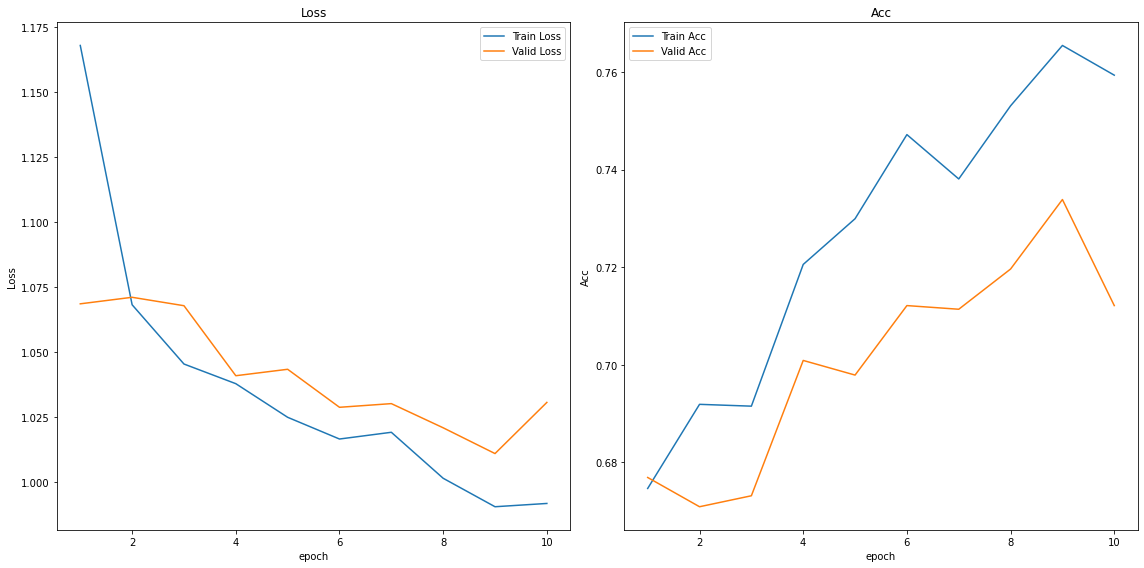

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 8))

epoch_size = range(1, 11)
plt.subplot(1,2,1)
plt.plot(epoch_size, train_loss, label='Train Loss')
plt.plot(epoch_size, valid_loss, label='Valid Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_size, train_acc, label='Train Acc')
plt.plot(epoch_size, valid_acc, label='Valid Acc')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.title('Acc')
plt.legend()

plt.tight_layout()
plt.show();

# 83. ミニバッチ化・GPU上での学習
>問題82のコードを改変し，B
事例ごとに損失・勾配を計算して学習を行えるようにせよ（B
の値は適当に選べ）．また，GPU上で学習を実行せよ

`torch.tensor(train_x_vec)`のコードを実行すると  
`ValueError: expected sequence of length 12 at dim 1 (got 9)`となる.  
これは`torch.tensor([[1], [2, 0, 2], [8, 8]])`みたいなのがあった時, 
`torch.tensor([[1, 0, 0], [2, 0, 2], [8, 8, 0]])`として各要素の長さを揃えてあげないとだめ

In [30]:
def batch_trainee(batch_size):
    # Dataloaderを使ってtrain_x, train_yをまとめて扱う   [[x_vec, y], ...[x_vec, y]]
    train_y_vec = [category_to_num(y) for y in train_y]
    train_x_vec = [text_to_ids(x) for x in train_x]
    dataset = torch.utils.data.TensorDataset(list_to_tensor(train_x_vec), train_y_vec)

    # バッチサイズの指定
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # 最適化手法の指定
    optimizer = optim.SGD(my_rnn.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()


    epoch_size = 10
    train_loss = list()
    train_acc = list()
    valid_loss = list()
    valid_acc = list()

    start_time = time.time()
    for epoch in range(epoch_size):   # エポック数分ループを回す
        print(f'epoch{epoch}')
        running_loss = 0.0
    
        for input_x, label_y in data_loader:
            # print(input_x, label_y)
            # パラメータの勾配をリセット
            optimizer.zero_grad()
        
            # 順伝搬
            output = my_rnn(input_x)
            loss = criterion(output, label_y)
        
            # 逆伝搬
            loss.backward()
        
            # パラメータ更新
            optimizer.step()
        
            running_loss += loss.item()
    
        run_time = time.time() - start_time
    
        # 学習の記録
        train_loss.append(running_loss/len(train_x))
        train_acc.append(get_accuracy(my_rnn, train_x, train_y))
    
        acc, loss = get_dataset_acc_loss(my_rnn, criterion, valid_x, valid_y)
        valid_loss.append(loss)
        valid_acc.append(acc)
    
    print('Done.')
    print(f'Run Time  : {run_time}')
    print(f'Train_Acc: {train_acc.mean()}')
    print(f'Valid_Acc: {valid_acc.mean()}')

In [31]:
batch_trainee(100)

ValueError: expected sequence of length 12 at dim 2 (got 9)

In [29]:
train_x_vec = [text_to_ids(input_x) for input_x in train_x]
list_to_tensor(train_x_vec)

ValueError: expected sequence of length 12 at dim 1 (got 9)